In [2]:
import numpy as np
from numpy.testing import assert_equal
from scipy.integrate import complex_ode
#from scipy.stats import kurtosis
from scipy.stats import moment

# time measurement
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

import tensorflow as tf

In [3]:
"""Simulated Environment of the Deep RL Model"""

def laser_simulation(uvt, alpha1, alpha2, alpha3, alphap,K):
    # parameters of the Maxwell equation
    
    D = -0.4
    E0 = 4.23
    tau = 0.1
    g0 = 1.73
    Gamma = 0.1
    
    
    Z = 1.5         # cavity length
    T = 60
    n = 256       # t slices
    Rnd = 500     # round trips
    t2 = np.linspace(-T/2,T/2,n+1)
    t_dis = t2[0:n].reshape([1,n])   # time discretization
    k = (2*np.pi/T)*np.concatenate((np.linspace(0,n//2-1,n//2),
                          np.linspace(-n//2,-1,n//2)),0)
    ts=[]
    ys=[]
    t0=0.0
    tend=1
    
    # waveplates & polarizer
    W4 = np.array([[np.exp(-1j*np.pi/4), 0],[0, np.exp(1j*np.pi/4)]]); # quarter waveplate
    W2 = np.array([[-1j, 0],[0, 1j]]);  # half waveplate
    WP = np.array([[1, 0], [0, 0]]);  # polarizer
    
    # waveplate settings
    R1 = np.array([[np.cos(alpha1), -np.sin(alpha1)], 
                   [np.sin(alpha1), np.cos(alpha1)]])
    R2 = np.array([[np.cos(alpha2), -np.sin(alpha2)], 
                   [np.sin(alpha2), np.cos(alpha2)]])
    R3 = np.array([[np.cos(alpha3), -np.sin(alpha3)], 
                   [np.sin(alpha3), np.cos(alpha3)]])
    RP = np.array([[np.cos(alphap), -np.sin(alphap)], 
                   [np.sin(alphap), np.cos(alphap)]])
    J1 = np.matmul(np.matmul(R1,W4),np.transpose(R1))
    J2 = np.matmul(np.matmul(R2,W4),np.transpose(R2))
    J3 = np.matmul(np.matmul(R3,W2),np.transpose(R3))
    JP = np.matmul(np.matmul(RP,WP),np.transpose(RP))

    
    # transfer function
    Transf = np.matmul(np.matmul(np.matmul(J1,JP),J2),J3)

    
    urnd=np.zeros([Rnd, n], dtype=complex)
    vrnd=np.zeros([Rnd, n], dtype=complex)
    t_dis=t_dis.reshape(n,)
    energy=np.zeros([1,Rnd])
    
    # definition of the rhs of the ode
    def mlock_CNLS_rhs(ts, uvt):
        [ut_rhs,vt_rhs] = np.split(uvt,2)
        u = np.fft.ifft(ut_rhs)
        v = np.fft.ifft(vt_rhs)
        # calculation of the energy function
        E = np.trapz(np.conj(u)*u+np.conj(v)*v,t_dis)
        
        # u of the rhs
        urhs = -1j*0.5*D*(k**2)*ut_rhs - 1j*K*ut_rhs + \
                1j*np.fft.fft((np.conj(u)*u+ (2/3)*np.conj(v)*v)*u + \
                              (1/3)*(v**2)*np.conj(u)) + \
                2*g0/(1+E/E0)*(1-tau*(k**2))*ut_rhs - Gamma*ut_rhs
        
        # v of the rhs
        vrhs = -1j*0.5*D*(k**2)*vt_rhs + 1j*K*vt_rhs + \
                1j*np.fft.fft((np.conj(v)*v+(2/3)*np.conj(u)*u)*v + \
                              (1/3)*(u**2)*np.conj(v) ) + \
                2*g0/(1+E/E0)*(1-tau*(k**2))*vt_rhs - Gamma*vt_rhs
         
        return np.concatenate((urhs, vrhs),axis=0)

    
    # definition of the solution output for the ode integration
    def solout(t,y):
        ts.append(t)
        ys.append(y.copy())
        
    start = time.time()
    
    uv_list = []
    norms = []
    change_norm = 100
    jrnd = 0
    # solving the ode for Rnd rounds
    while(jrnd < Rnd and change_norm > 1e-6):
        ts = []
        ys = []
        
        t0 = Z*jrnd
        tend = Z*(jrnd+1)
        
        uvtsol = complex_ode(mlock_CNLS_rhs)
        # uvtsol = complex_ode(test_rhs)
        uvtsol.set_integrator(method='adams', name='dop853') # alternative 'dopri5'
        uvtsol.set_solout(solout)
        uvtsol.set_initial_value(uvt, t0)
        sol = uvtsol.integrate(tend)
        assert_equal(ts[0], t0)
        assert_equal(ts[-1], tend)
    
        
        u=np.fft.ifft(sol[0:n])
        v=np.fft.ifft(sol[n:2*n])
        
        urnd[jrnd,:]=u
        vrnd[jrnd,:]=v
        energy[0, jrnd]=np.trapz(np.abs(u)**2+np.abs(v)**2,t_dis)
        
        uvplus=np.matmul(Transf,np.transpose(np.concatenate((u.reshape(n,1),
                                                              v.reshape(n,1)),axis=1)))
        uv_list.append(np.concatenate((uvplus[0,:],
                                       uvplus[1,:]), axis=0))
        
        uvt=np.concatenate((np.fft.fft(uvplus[0,:]),
                                       np.fft.fft(uvplus[1,:])), axis=0)
        
        if jrnd > 0:
            phi=np.sqrt(np.abs(np.vstack(uv_list)[:,:n])**2 + \
                        np.abs(np.vstack(uv_list)[:,n:2*n])**2)
            change_norm=np.linalg.norm((phi[-1,:]-phi[len(phi)-2,:]))/ \
            np.linalg.norm(phi[len(phi)-2,:])
            norms.append(change_norm) 
            
        jrnd += 1
    
    
    kur = np.abs(np.fft.fftshift(np.fft.fft(phi[-1,:])))
    #M4 = kurtosis(kur)
    M4 = moment(kur,4)/np.std(kur)**4
    
    end = time.time()
    print(end-start)
    
    E = np.sqrt(np.trapz(phi[-1,:]**2, t_dis))
    
    states = np.array([E, M4, alpha1, alpha2, alpha3, alphap])
    
    
    # surface plot 
    # create meshgrid
    X, Y = np.meshgrid(t_dis,np.arange(0,len(norms)))
    
    # figure urnd
    fig_urand = plt.figure()
    # ax = fig_urand.gca(projection='3d')
    ax = Axes3D(fig_urand)
    
    # plot the surface
    surf = ax.plot_surface(X, Y, np.abs(urnd[:len(norms),:]), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    
    # Add a color bar which maps values to colors.
    fig_urand.colorbar(surf, shrink=0.5, aspect=5)
    
    
    # figure vrnd
    fig_vrand = plt.figure()
    # ax = fig_vrand.gca(projection='3d')
    ax = Axes3D(fig_vrand)
    
    # plot the surface
    surf = ax.plot_surface(X, Y, np.abs(vrnd[:len(norms),:]), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    
    # Add a color bar which maps values to colors.
    fig_vrand.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()
    
    return (uvt,states)

In [4]:
def sech(x):
    # definition of the sech-function
    return np.cosh(x)**(-1)

In [5]:
def whitenoise(x):
    # white noise 
    n = np.shape(x)[1]
    return 0.5*(np.random.random(n)+1j*np.random.random(n))

In [7]:
T = 60
n = 256
t2 = np.linspace(-T/2,T/2,n+1)
t_dis = t2[0:n].reshape([1,n])      # time discretization

1.2448959350585938


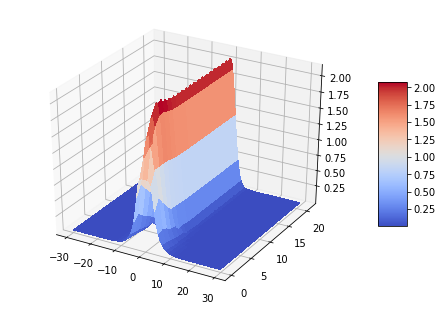

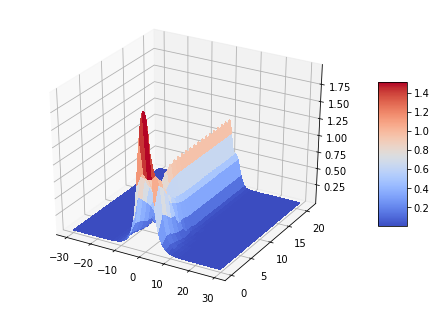

Laser states: [ 3.46517751 16.78334733 -0.41887902  0.05235988  0.48869219  1.53588974], reward: 0.20646522046042234


In [8]:
u = 0.5*np.reshape(sech(t_dis/2), [n,])   # orthogonally polarized electric field 
v = 0.5*np.reshape(sech(t_dis/2), [n,])   # envelopes in the optical fiber

ut=np.fft.fft(u).reshape(n,)        # fast fourier transformation of the
vt=np.fft.fft(v).reshape(n,)        # electrical fields
uvt=np.concatenate([ut, vt], axis=0)# concatenation of ut and vt
(uvt_cur,states) = laser_simulation(uvt, -24*np.pi/180, 3*np.pi/180, 28*np.pi/180, 88*np.pi/180, 0.1)
            
print('Laser states: %s, reward: %s' % (states, states[0]/states[1]))

In [9]:
class DoubleDQN(object):
    def __init__(self, n, n_actions, batch_size=8, double_dqn=False, learning_rate=0.002,
                 epsilon=1.0, epsilon_decay_rate=0.9998, gamma=0.99):
        self.n = n
        self.n_actions = n_actions
        self.double_dqn = double_dqn
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.gamma = gamma
        self.batch_size = batch_size

        self.learning_step = 0
        self.tau = 0.01

        self.memory_size = 12000
        self.memory_counter = 0
        self.memory = np.zeros([self.memory_size, self.n*4*2+3*1+4*2])

        self._build_net()
        
        
        self.e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_net')
        self.t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
        
        self.update_params_op = [tf.assign(t, (1 - self.tau) * t + self.tau * e) for t, e in zip(self.t_params, self.e_params)]

    def _build_net(self):

        k_init, b_init = tf.random_uniform_initializer(0., 0.2), tf.constant_initializer(0.1)

        # build eval net
        self.s = tf.placeholder(tf.float32, [None, 4*self.n+4], name='s')
        self.a = tf.placeholder(tf.int32, [None], name='a')
        self.s_ = tf.placeholder(tf.float32, [None, 4*self.n+4], name='s_')
        self.q_target = tf.placeholder(tf.float32, [None], name='q_target')
        
        h000_units = 67
        h00_units = 66
        h0_units = 65
        h1_units = 256
        h2_units = 128
        h3_units = 81
        

        with tf.variable_scope('eval_net'):
            
            self.s_expand = tf.expand_dims(self.s, -1)
            self.state = tf.concat([self.s_expand[:,:self.n,:], self.s_expand[:, self.n:self.n*2,:], 
                               self.s_expand[:, self.n*2:self.n*3,:],self.s_expand[:, self.n*3:self.n*4,:]], axis=-1, name='concat_uv')
            self.state = tf.expand_dims(self.state, -1)
            self.conv_1 = tf.layers.conv2d(inputs=self.state, filters=16, kernel_size=[3, 3], padding="same", activation=tf.nn.relu, name='conv_1', trainable=False)
            self.max_1 = tf.layers.max_pooling2d(self.conv_1, (2,2), (2,2), padding='same', name='max_1')
            self.conv_2 = tf.layers.conv2d(inputs=self.max_1, filters=4, kernel_size=[3, 3], padding="same", activation=tf.nn.relu, name='conv_2', trainable=False)
            self.max_2 = tf.layers.max_pooling2d(self.conv_2, (2,2), (2,2), padding='same', name='max_2')
            self.conv_3 = tf.layers.conv2d(inputs=self.max_2, filters=1, kernel_size=[2, 2], padding="same", activation=None, name='conv_3', trainable=False)
            
            self.state_dense = tf.abs(tf.squeeze(self.conv_3, [2, 3]))                               
             
            self.s_dense = tf.concat([self.state_dense, self.s[:,-4:]], axis=-1, name='dense_s') 
            
            
            self.hidden_eval_000 = tf.layers.dense(inputs=self.s_dense, units=h000_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_eval_000')            
            self.hidden_eval_00 = tf.layers.dense(inputs=self.hidden_eval_000, units=h00_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_eval_00') 
            self.hidden_eval_0 = tf.layers.dense(inputs=self.hidden_eval_00, units=h0_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_eval_0')           
            self.hidden_eval_1 = tf.layers.dense(inputs=self.hidden_eval_0, units=h1_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_eval_1')
            self.hidden_eval_2 = tf.layers.dense(inputs=self.hidden_eval_1, units=h2_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_eval_2')
            self.hidden_eval_3 = tf.layers.dense(inputs=self.hidden_eval_2, units=h3_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_eval_3')
            
            
            self.eval_net = tf.layers.dense(inputs=self.hidden_eval_3, units=self.n_actions, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                            bias_initializer=b_init, name='eval_net')

        # build target net
        with tf.variable_scope('target_net'):
            
            self.s_expand_ = tf.expand_dims(self.s_, -1)
            self.state_ = tf.concat([self.s_expand_[:,:self.n,:], self.s_expand_[:, self.n:self.n*2,:],
                                     self.s_expand_[:, self.n*2:self.n*3,:],self.s_expand_[:, self.n*3:self.n*4,:]], axis=-1, name='concat_uv_')
            self.state_ = tf.expand_dims(self.state_, -1)
            self.conv_1_ = tf.layers.conv2d(inputs=self.state_, filters=16, kernel_size=[3, 3], padding="same", activation=tf.nn.relu, name='conv_1_', trainable=False)
            self.max_1_ = tf.layers.max_pooling2d(self.conv_1_, (2,2), (2,2), padding='same', name='max_1_')
            self.conv_2_ = tf.layers.conv2d(inputs=self.max_1_, filters=4, kernel_size=[3, 3], padding="same", activation=tf.nn.relu, name='conv_2_', trainable=False)
            self.max_2_ = tf.layers.max_pooling2d(self.conv_2_, (2,2), (2,2), padding='same', name='max_2_')
            self.conv_3_ = tf.layers.conv2d(inputs=self.max_2_, filters=1, kernel_size=[2, 2], padding="same", activation=None, name='conv_3_', trainable=False)
            
            self.state_dense_ = tf.abs(tf.squeeze(self.conv_3_, [2, 3]))
            
            self.s_dense_ = tf.concat([self.state_dense_, self.s_[:,-4:]], axis=-1, name='dense_s_')
                   
                
            self.hidden_tar_000 = tf.layers.dense(inputs=self.s_dense_, units=h000_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_tar_000')
            self.hidden_tar_00 = tf.layers.dense(inputs=self.hidden_tar_000, units=h00_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_tar_00')               
            self.hidden_tar_0 = tf.layers.dense(inputs=self.hidden_tar_00, units=h0_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_tar_0')    
            self.hidden_tar_1 = tf.layers.dense(inputs=self.hidden_tar_0, units=h1_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_tar_1')
            self.hidden_tar_2 = tf.layers.dense(inputs=self.hidden_tar_1, units=h2_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_tar_2')
            self.hidden_tar_3 = tf.layers.dense(inputs=self.hidden_tar_2, units=h3_units, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                           bias_initializer=b_init, name='hidden_tar_3')
            
            
            self.target_net = tf.layers.dense(inputs=self.hidden_tar_3, units=self.n_actions, activation=tf.nn.leaky_relu, kernel_initializer=k_init,
                                              bias_initializer=b_init, name='target_net')
            

        with tf.variable_scope('loss'):
            
            self.actions_reward = tf.multiply(self.eval_net, tf.one_hot(indices=self.a, depth=self.n_actions))
            self.actions_reward = tf.reduce_sum(self.actions_reward, reduction_indices=1)
            
            self.loss = tf.reduce_mean(tf.square(self.q_target - self.actions_reward))
    
            
        with tf.variable_scope('train'):
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)
            
    

    def choose_action(self, sess, s):
        s = s[np.newaxis, :]
        if np.random.uniform() > self.epsilon:
            action_values = sess.run(self.eval_net, feed_dict={self.s: s})
            action = np.argmax(action_values)
        else:
            action = np.random.choice(range(self.n_actions))
        return action
    
    def infer_action(self, sess, s):
        s = s[np.newaxis, :]       
        action_values = sess.run(self.eval_net, feed_dict={self.s: s})
        action = np.argmax(action_values)       
        return action
    
    
    def store_transition(self, s, a, r, s_, terminal):
        transition = np.hstack((s, a, r, s_, terminal))
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1
    

    def learn(self, sess):
        
        sess.run(self.update_params_op)

        if self.memory_counter <= self.memory_size:
            index = np.random.choice(self.memory_counter, self.batch_size)
        else:
            index = np.random.choice(self.memory_size, self.batch_size)
        batch_memory = self.memory[index, :]

        bs = batch_memory[:, :4*self.n+4]
        ba = batch_memory[:, 4*self.n+4]
        br = batch_memory[:, 4*self.n+5]
        bs_ = batch_memory[:, 4*self.n+6:-1]
        bt = batch_memory[:, -1]

        q_target_next = sess.run(self.target_net, feed_dict={self.s_: bs_})

        if self.double_dqn:
            q_eval_next = sess.run(self.eval_net, feed_dict={self.s: bs_})
            a4next = np.argmax(q_eval_next, axis=1)
            q_target = br + self.gamma * q_target_next[np.arange(self.batch_size, dtype=np.int32), a4next]*bt
        else:
            q_next = np.max(q_target_next, axis=1)
            q_target = br + self.gamma*q_next*bt

        _, loss = sess.run([self.train_op, self.loss],
                            feed_dict={self.s: bs,
                                       self.a: ba,
                                       self.q_target: q_target})
              
        self.epsilon *= self.epsilon_decay_rate
        
        self.learning_step += 1
        if (self.learning_step%1500)==0:
            self.learning_rate *= 0.5
            
        return loss
    

In [10]:
EPISODES = 2000
batch_size = 8

In [11]:
tf.reset_default_graph()
agent = DoubleDQN(n=n, n_actions=81, batch_size=2, double_dqn=True, learning_rate=0.002, epsilon=0.3, epsilon_decay_rate=0.9998, gamma=0.99)

In [13]:
ALPHA_CHANGE = []
for a1 in [-np.pi/360, 0, np.pi/360]:
    for a2 in [-np.pi/360, 0, np.pi/360]:
        for a3 in [-np.pi/360, 0, np.pi/360]:
            for a4 in [-np.pi/360, 0, np.pi/360]:
                ALPHA_CHANGE.append([a1, a2, a3, a4])
ALPHA_CHANGE=np.array(ALPHA_CHANGE)

In [12]:
def ddqn_infer(sess, K, alpha1_init, alpha2_init, alpha3_init, alpha4_init, alpha_change, max_step=50):
    alpha1_cur = alpha1_init   
    alpha2_cur = alpha2_init
    alpha3_cur = alpha3_init
    alpha4_cur = alpha4_init
    
    u=0.5*np.reshape(sech(t_dis/2), [n,])   # orthogonally polarized electric field
    v=0.5*np.reshape(sech(t_dis/2), [n,])   # envelopes in the optical fiber
    uv=np.concatenate([u, v], axis=0)
    
    ut=np.fft.fft(u).reshape(n,)                         # fast fourier transformation of the
    vt=np.fft.fft(v).reshape(n,)                         # electrical fields
    uvt=np.concatenate([ut, vt], axis=0)                 # concatenation of ut and vt
    s = np.concatenate((uv.real, uv.imag, 1.0*np.array([alpha1_cur, alpha2_cur, alpha3_cur, alpha4_cur])), axis=0)      # birefringence K is not taken as part of state here (we assume constant K)
   
    
    rewards = []
    ep_step = 0
    cur_a = []
    while True:
        a = agent.infer_action(sess, s)
        alpha1_cur += alpha_change[a][0]
        alpha2_cur += alpha_change[a][1]
        alpha3_cur += alpha_change[a][2]
        alpha4_cur += alpha_change[a][3]
        
        (next_uvt, info) = laser_simulation(uvt, alpha1_cur, alpha2_cur, alpha3_cur, alpha4_cur, K)               
        next_u = np.fft.ifft(next_uvt[:n])
        next_v = np.fft.ifft(next_uvt[n:])
        next_uv = np.concatenate([next_u, next_v], axis=0)
        s_ = np.concatenate((next_uv.real,next_uv.imag, 1.0*np.array([alpha1_cur, alpha2_cur, alpha3_cur, alpha4_cur])), axis=0)
        r = info[0]/info[1]
        
        if ep_step >= max_step:
            break
        
        s = s_
        uvt = next_uvt
        ep_step += 1
        rewards.append(r)
        cur_a.append(a)
        
    print(rewards)
    print(cur_a)
    return rewards, cur_a
    

INFO:tensorflow:Restoring parameters from ./vary_K/01to00/run_3/ddqn_best
17.85714626312256


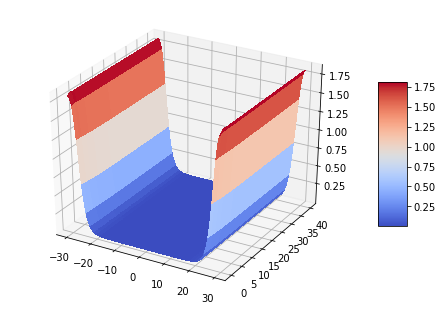

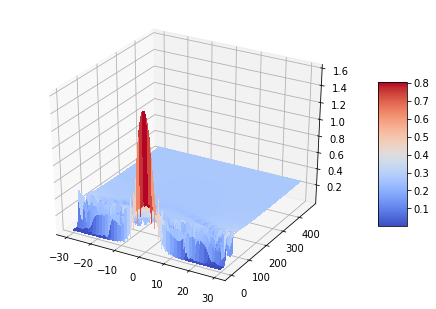

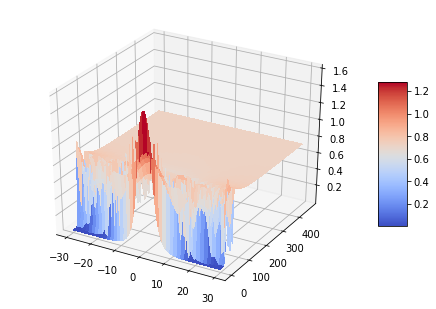

0.26900315284729004


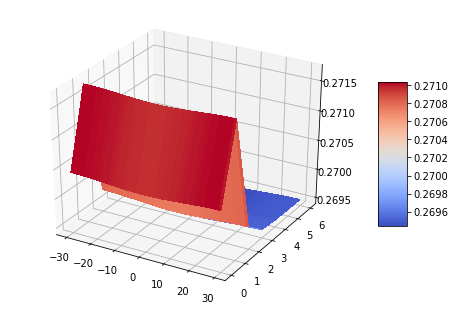

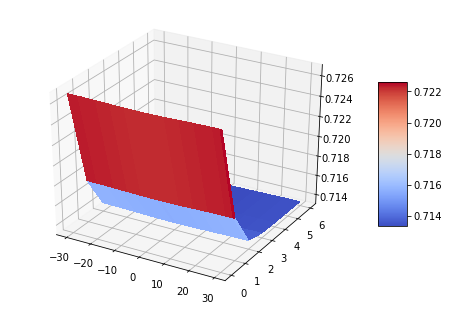

0.22884798049926758


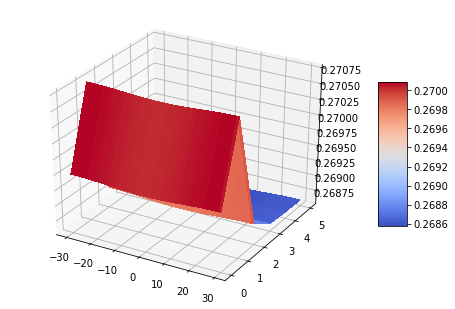

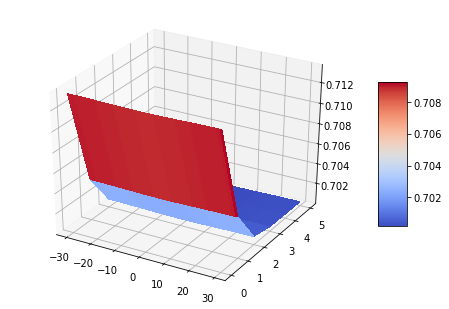

0.21893978118896484


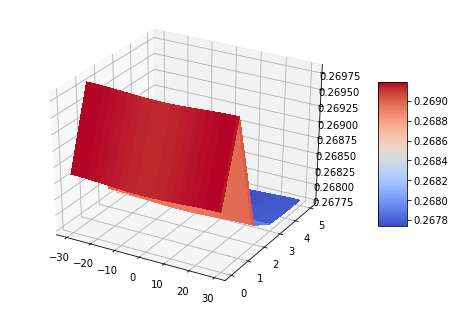

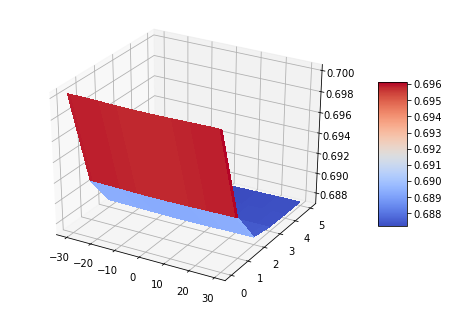

0.24924421310424805


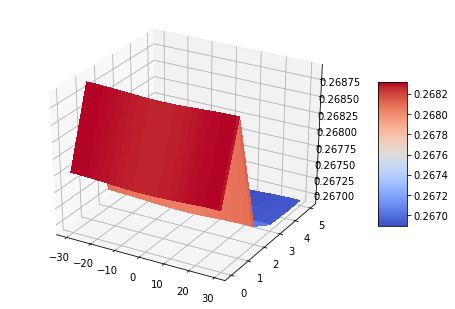

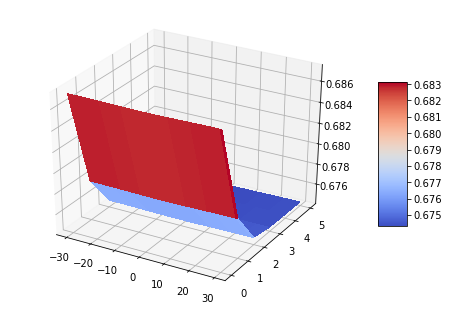

0.2363131046295166


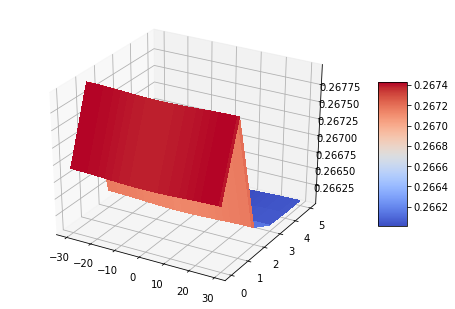

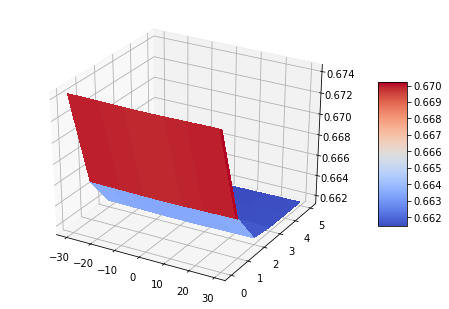

0.22344136238098145


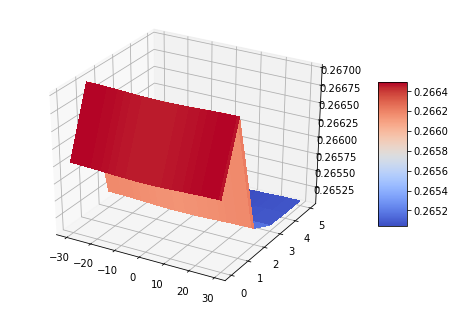

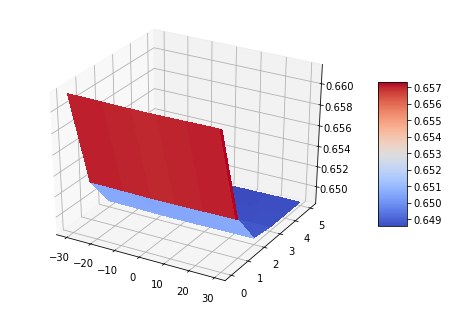

0.2114570140838623


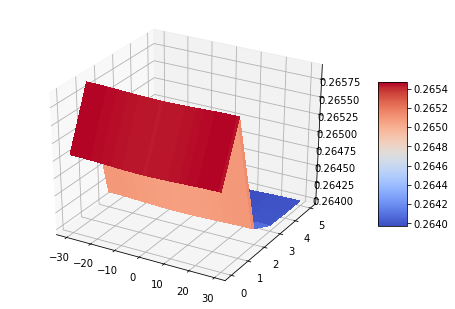

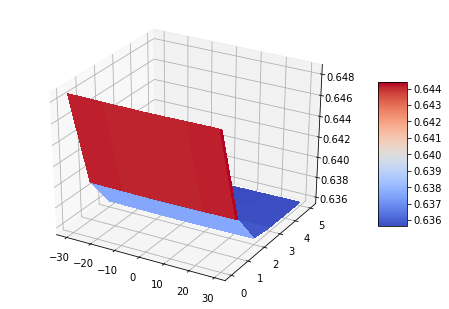

0.22005605697631836


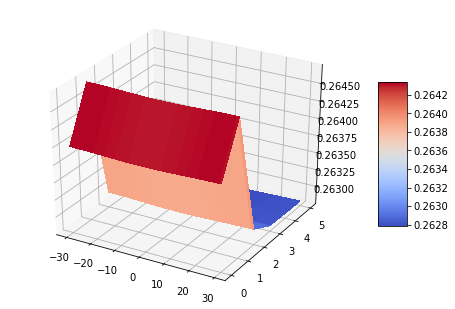

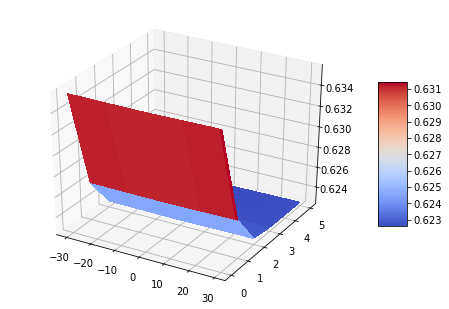

0.2321927547454834


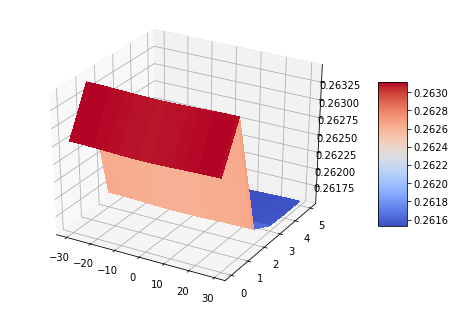

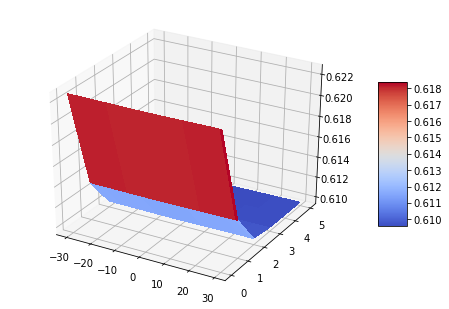

0.22537875175476074


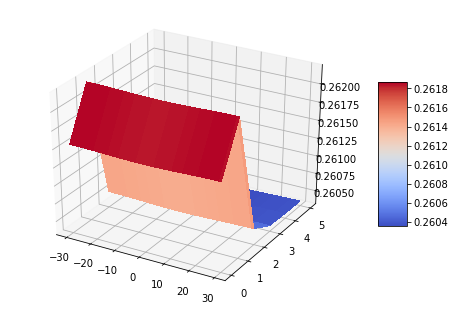

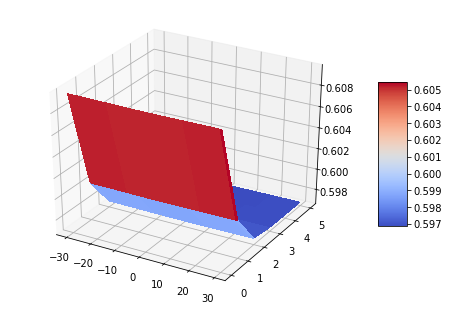

0.22922515869140625


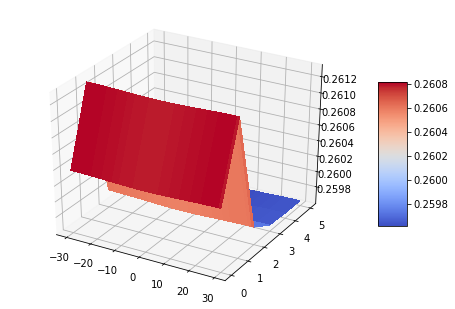

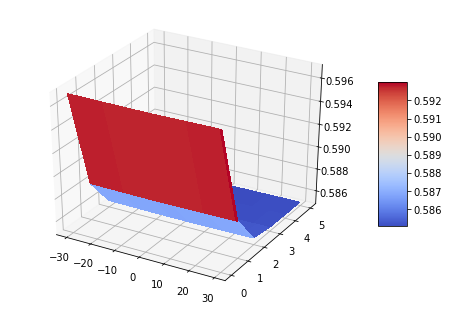

0.25922393798828125


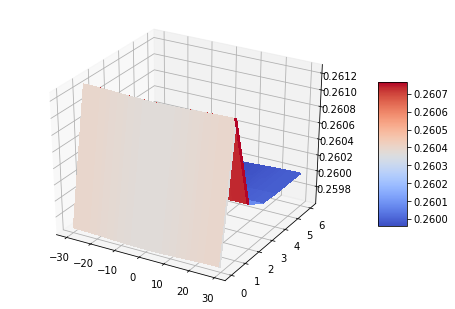

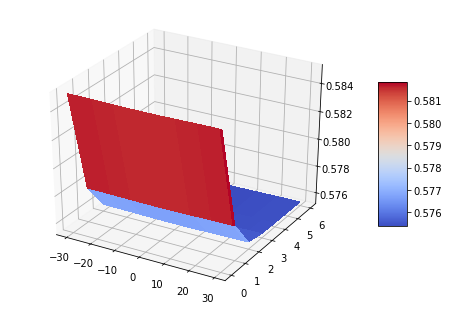

1.2414121627807617


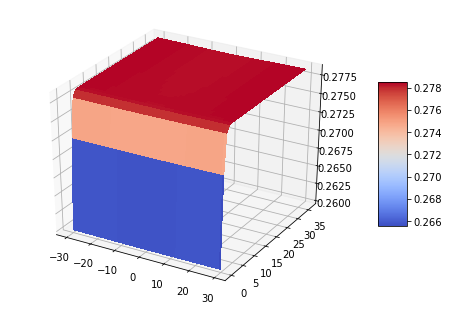

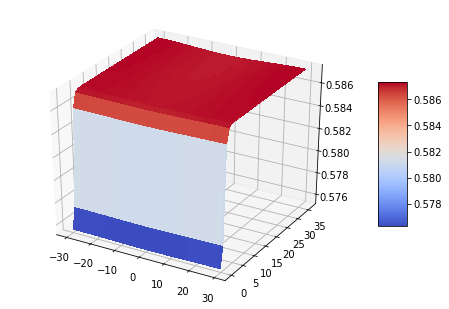

7.598598003387451


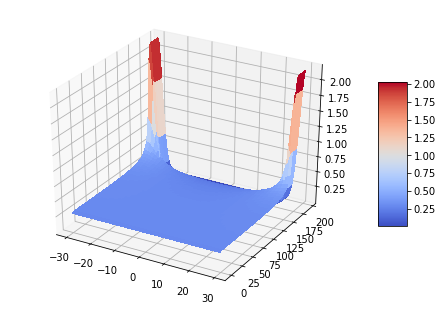

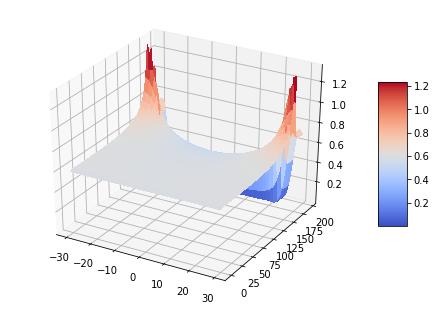

0.6893799304962158


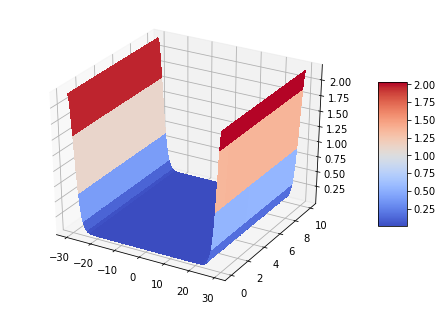

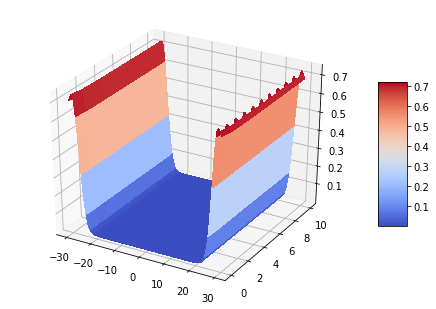

0.8456757068634033


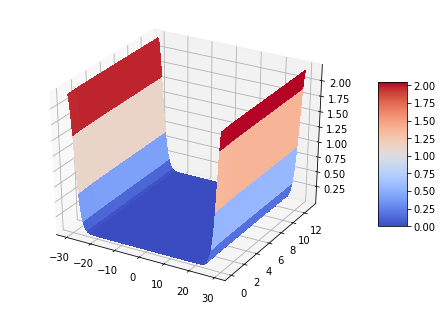

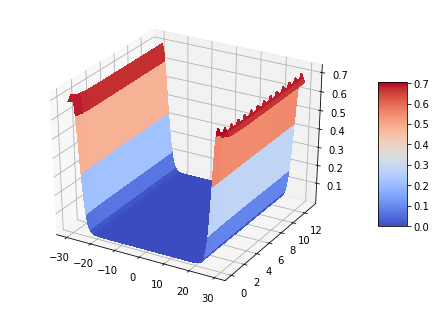

1.1294000148773193


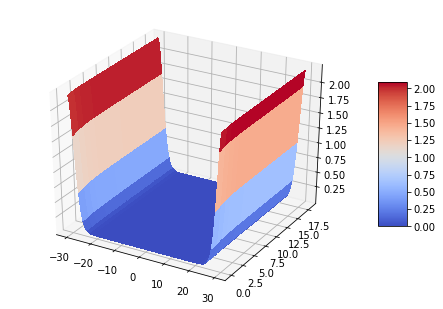

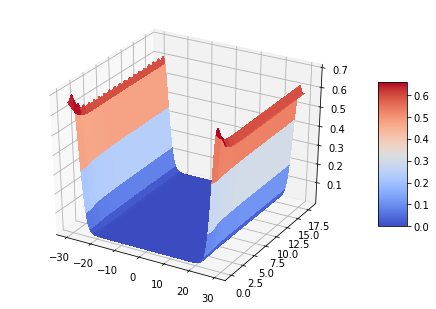

1.2615787982940674


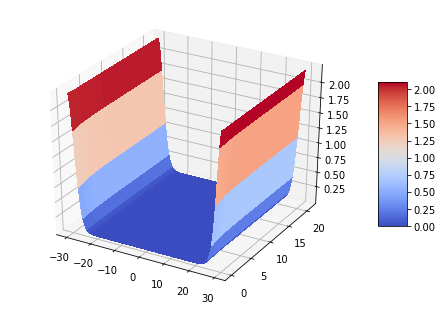

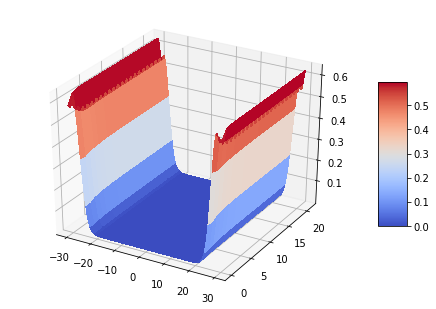

1.1713430881500244


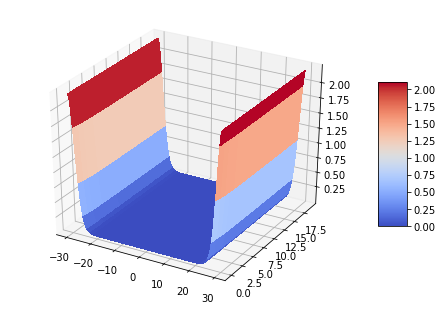

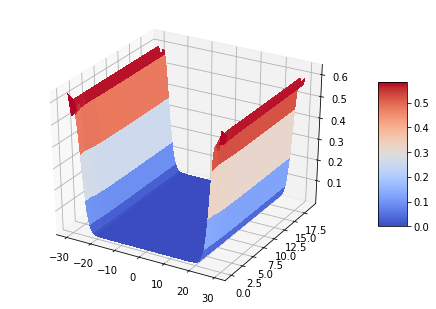

1.106860876083374


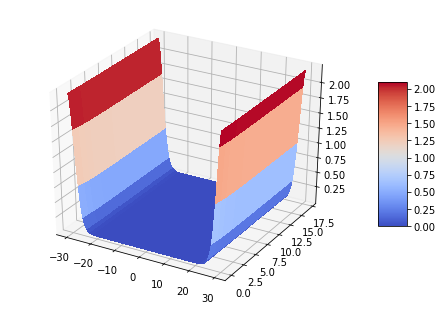

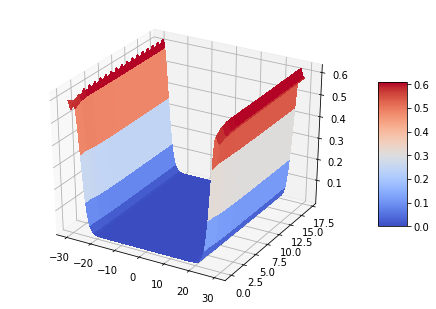

1.0114150047302246


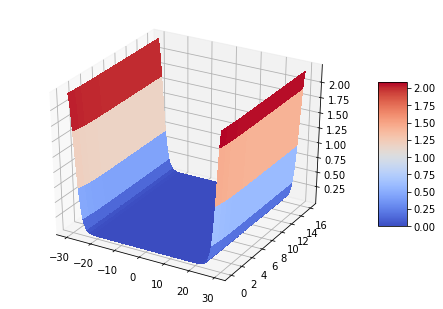

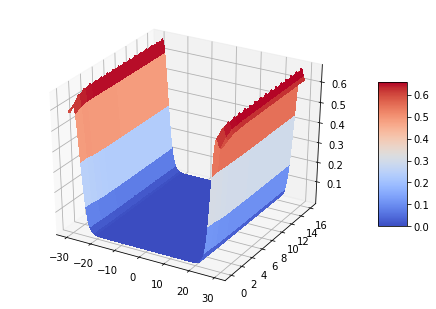

1.1937522888183594


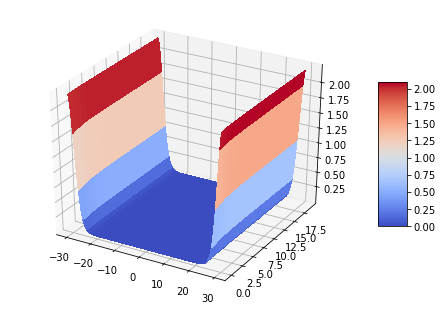

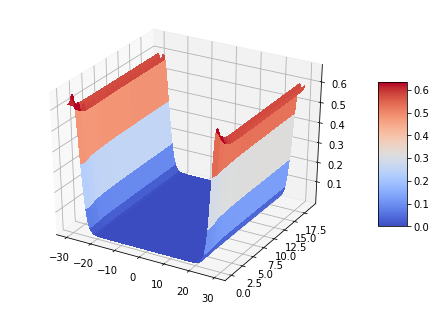

1.0953469276428223


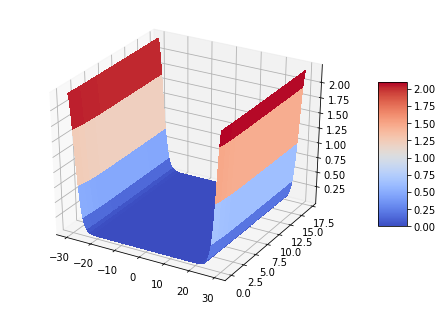

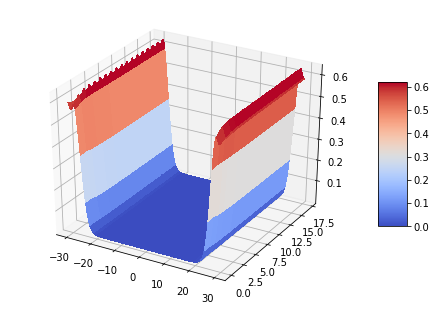

1.3025689125061035


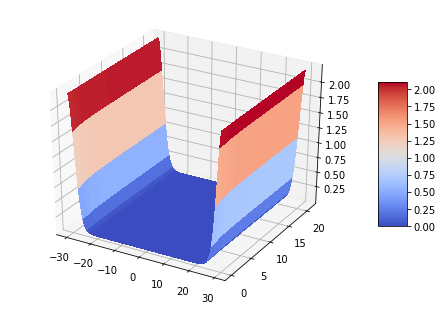

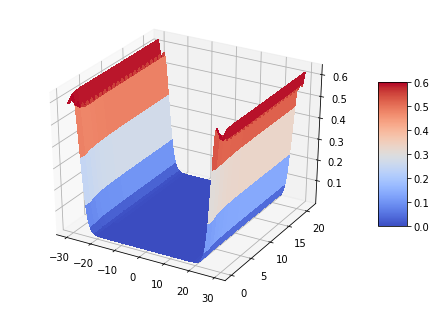

1.1337440013885498


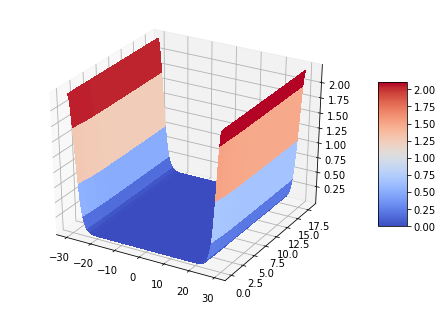

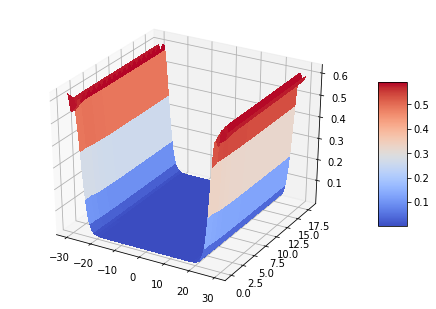

1.2848420143127441


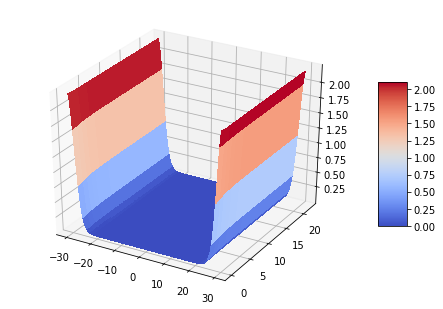

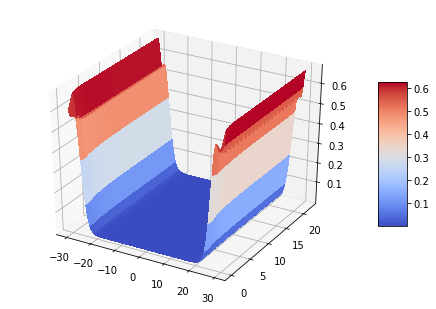

1.212291955947876


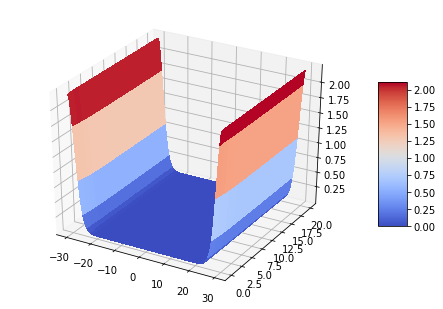

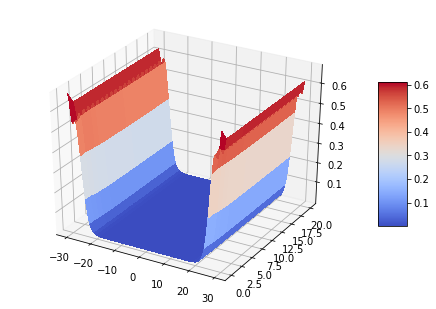

1.433133840560913


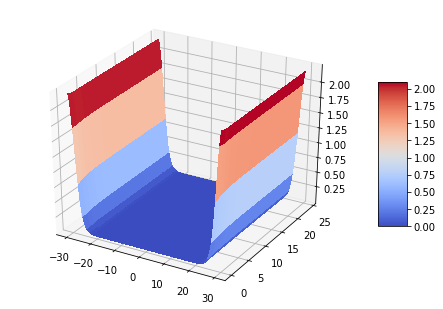

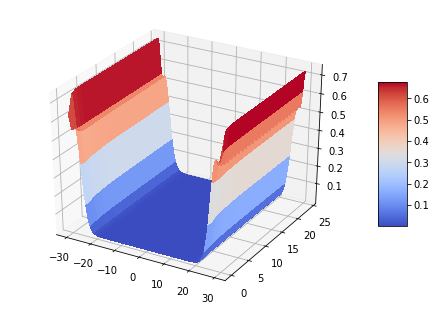

1.2615959644317627


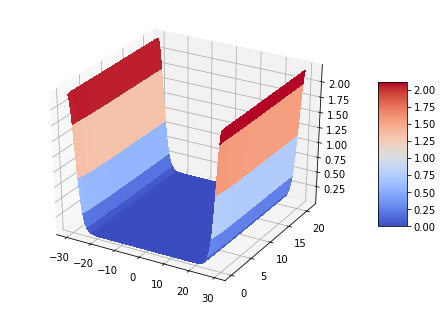

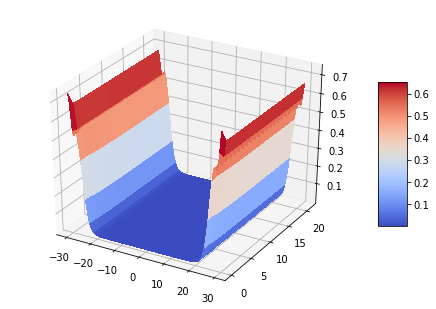

1.137423038482666


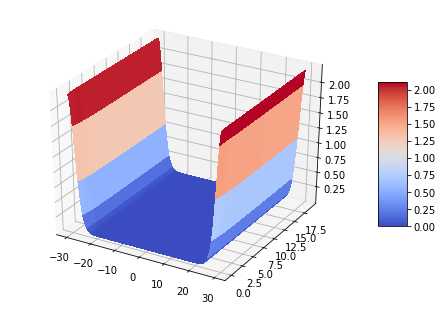

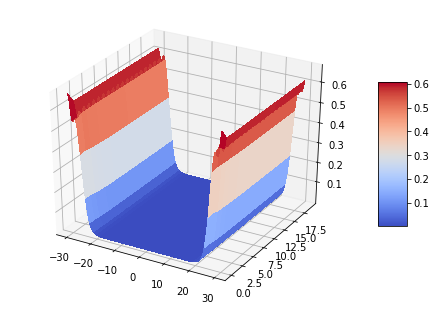

0.7917912006378174


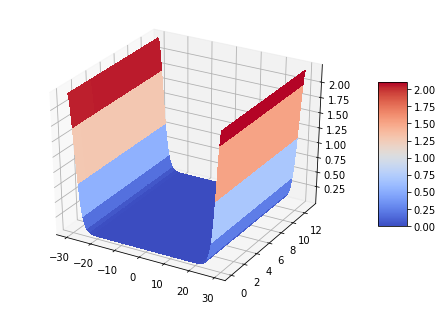

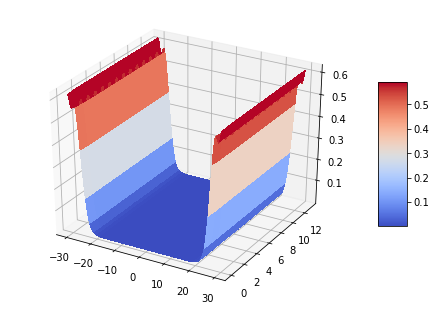

0.8238739967346191


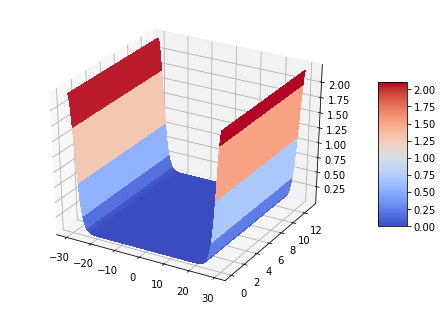

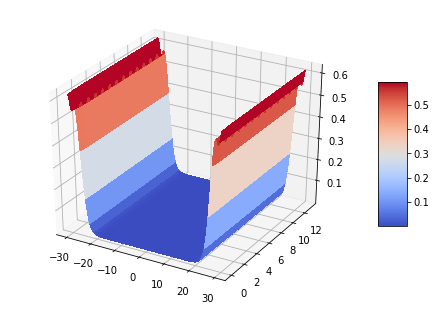

1.4162678718566895


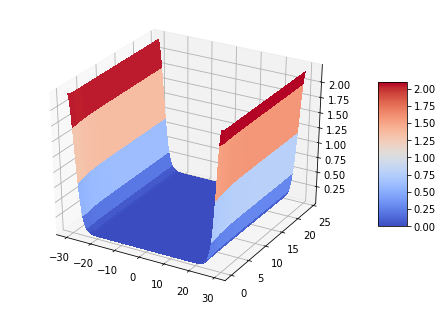

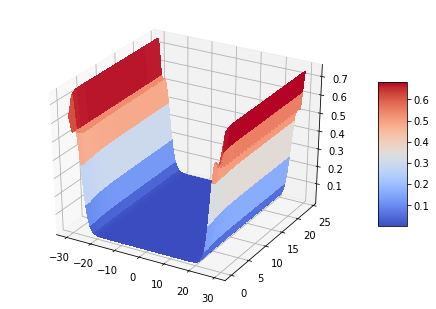

1.2248408794403076


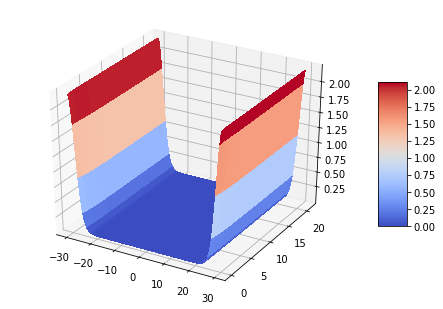

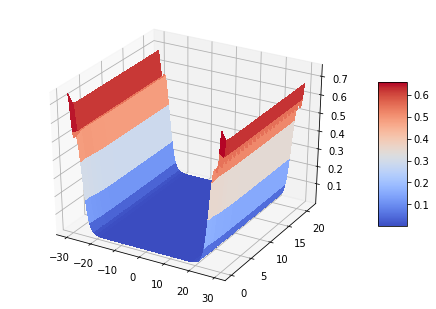

1.4547789096832275


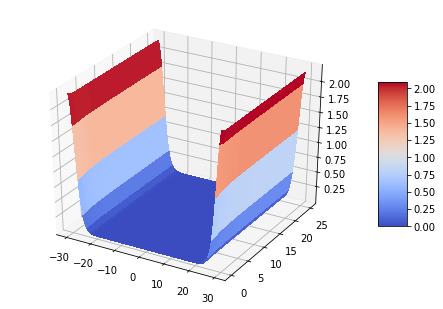

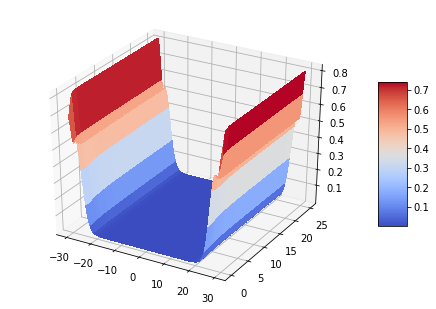

1.2625701427459717


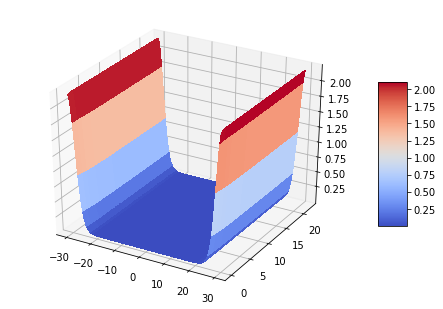

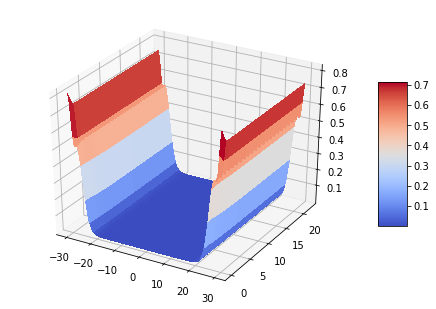

1.211850881576538


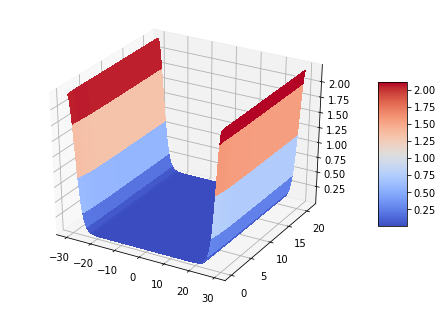

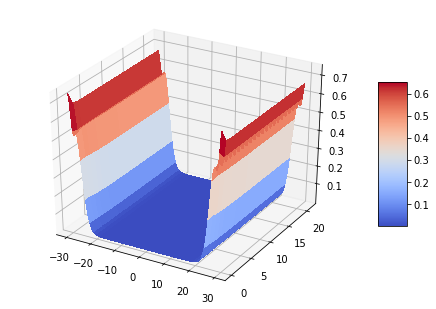

1.1074907779693604


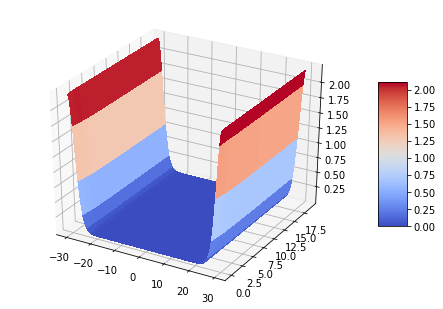

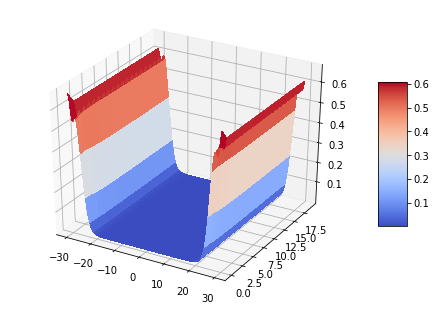

0.8021869659423828


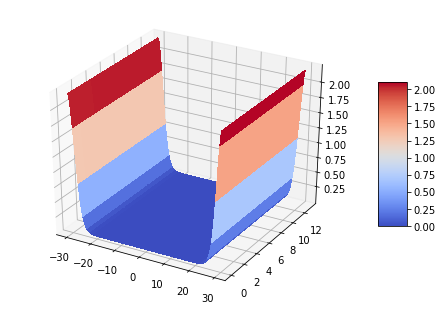

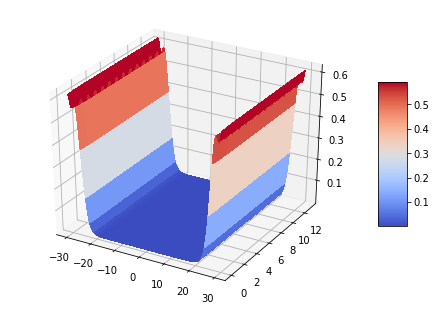

0.8076300621032715


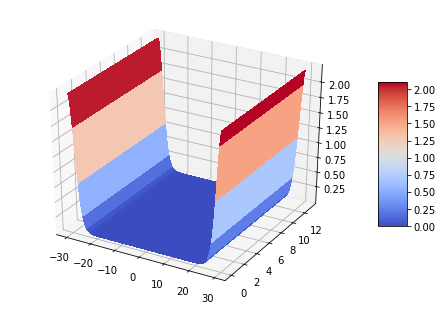

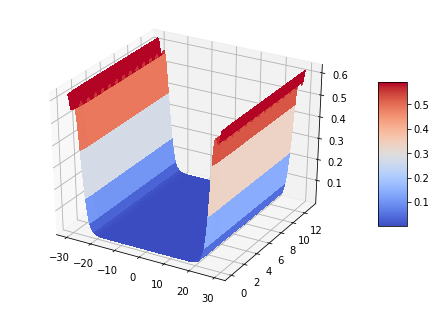

0.8050720691680908


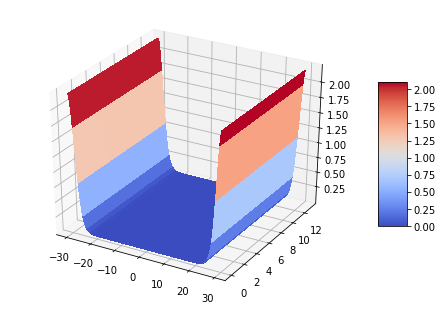

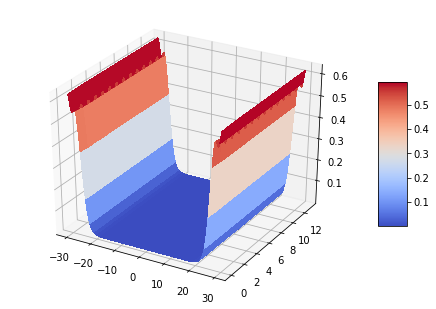

1.3516590595245361


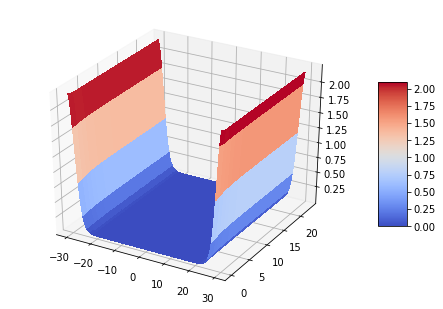

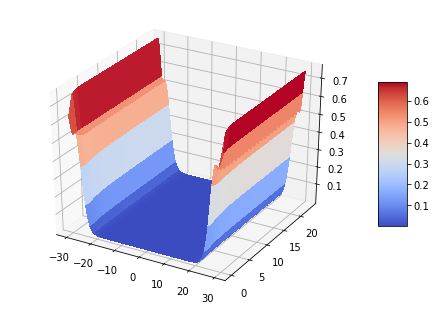

1.2167959213256836


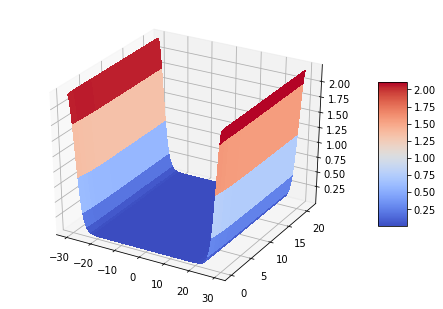

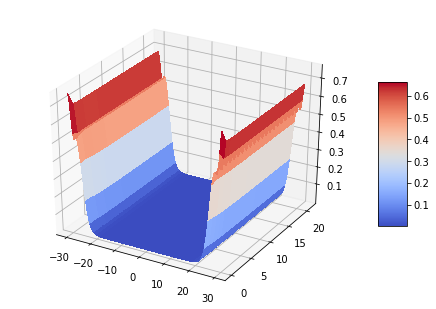

1.0956180095672607


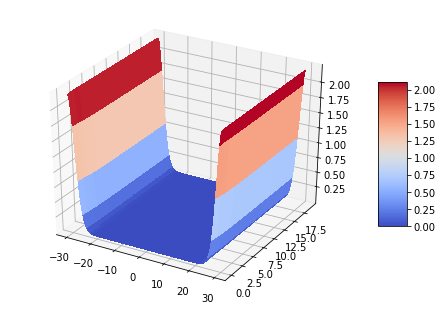

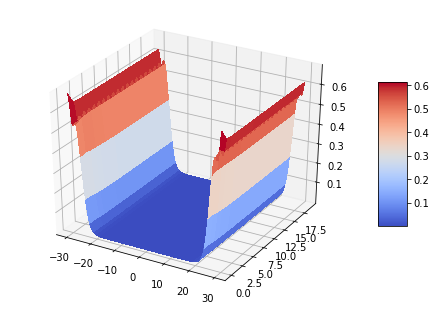

0.8150651454925537


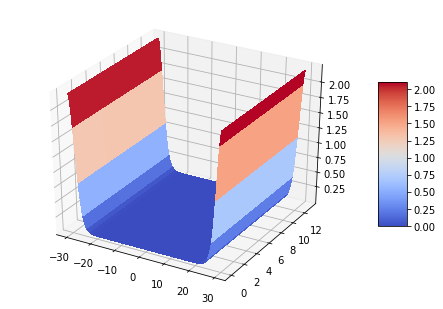

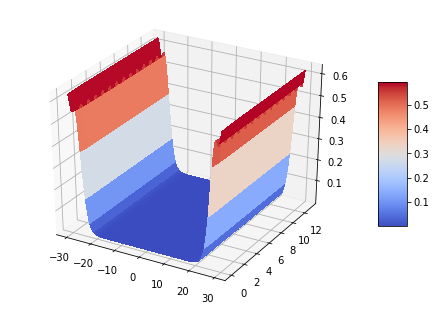

1.3060526847839355


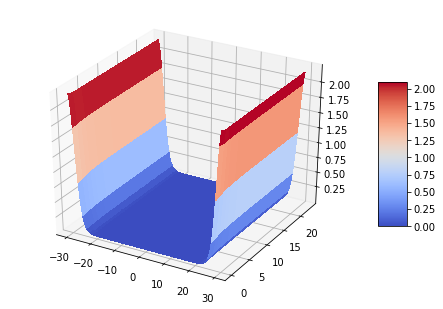

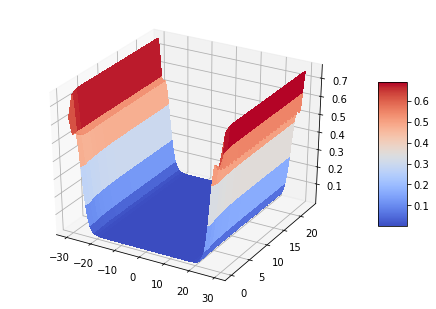

1.6021780967712402


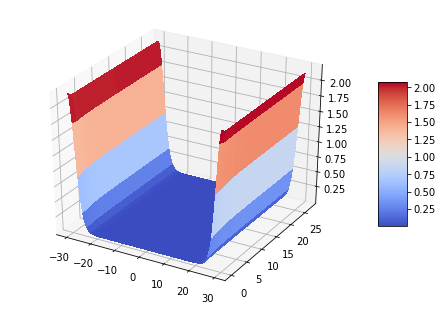

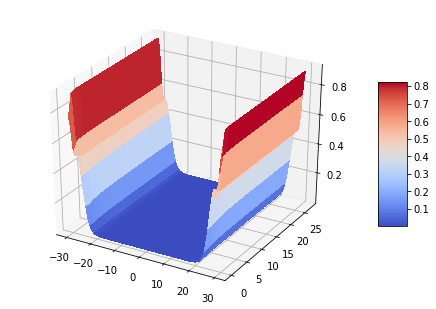

1.301732063293457


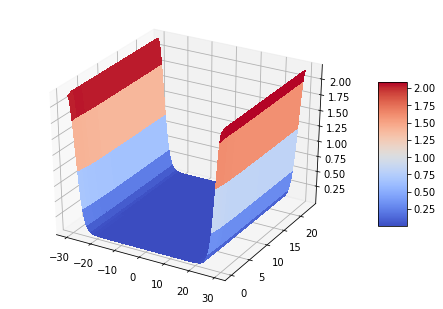

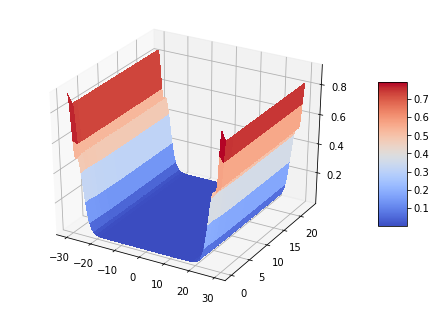

1.303853988647461


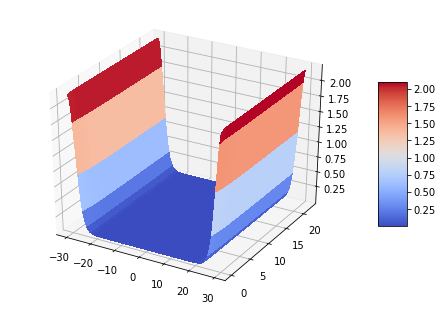

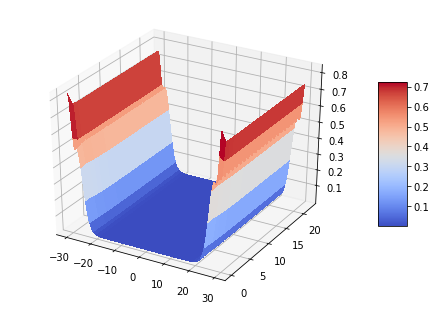

1.187195062637329


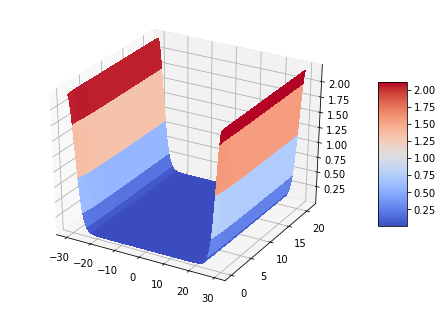

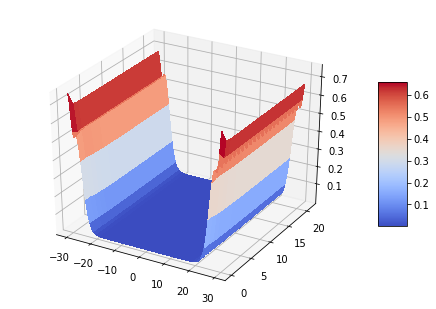

0.859130859375


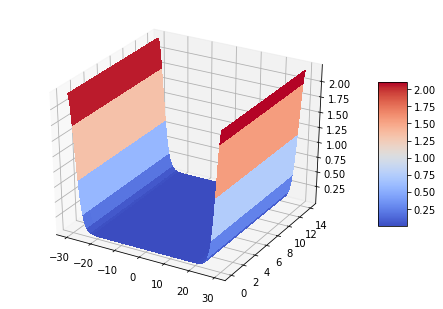

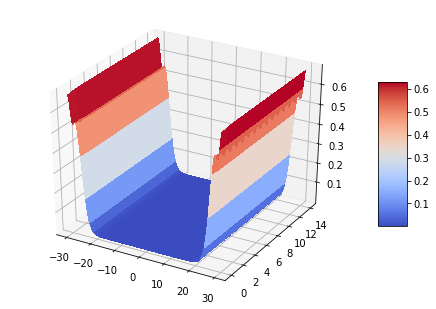

0.8468389511108398


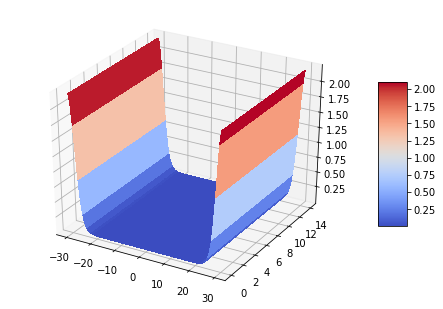

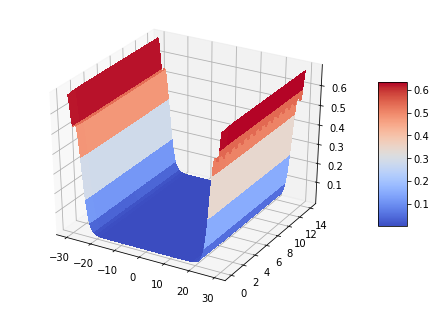

1.1156291961669922


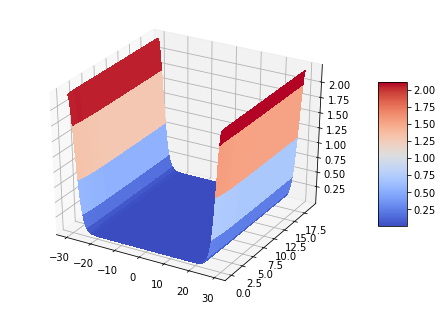

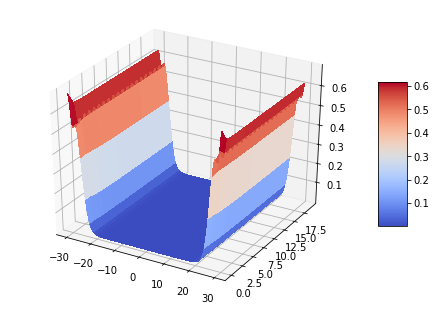

0.8033881187438965


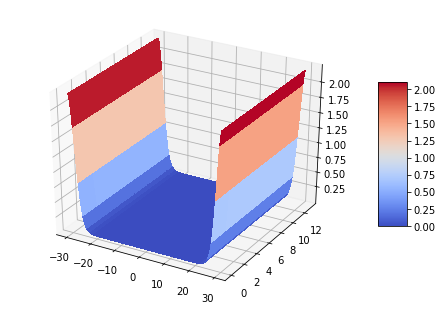

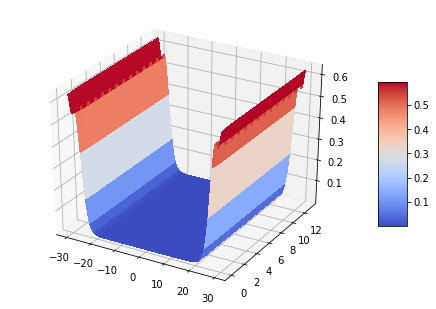

1.3879501819610596


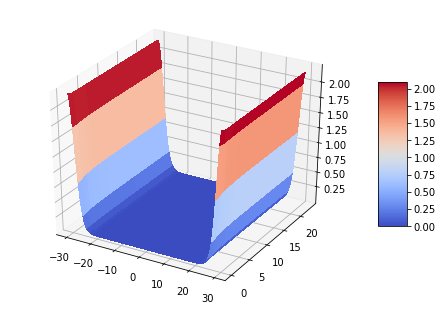

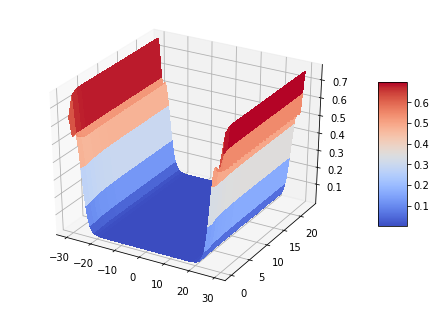

1.2464802265167236


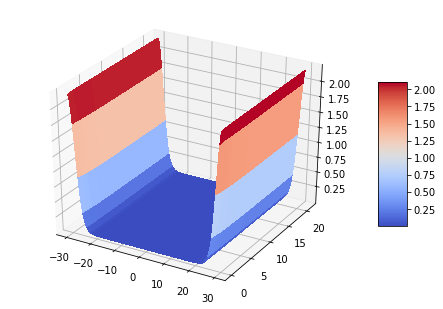

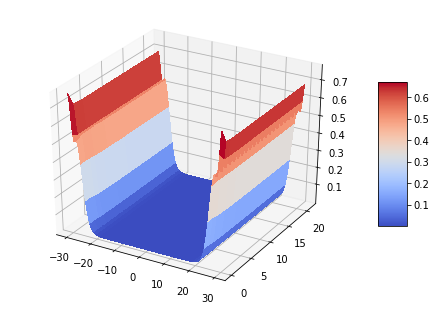

1.1913487911224365


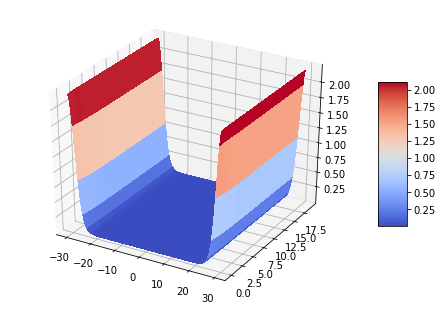

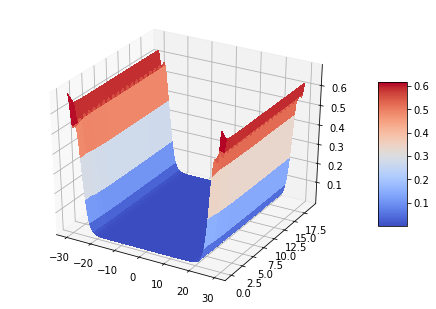

0.8474442958831787


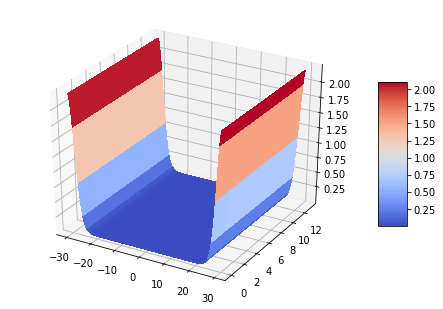

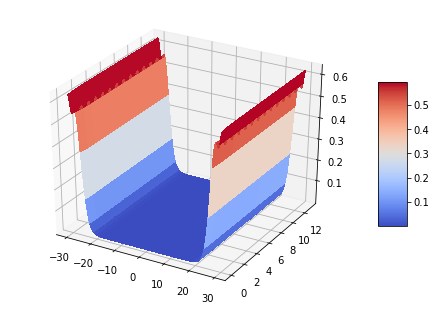

1.3858051300048828


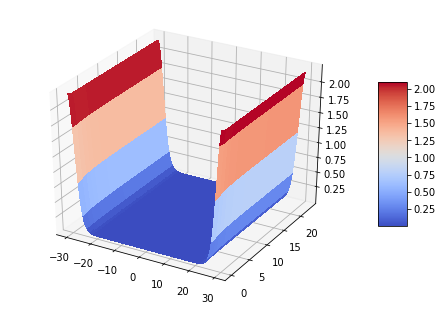

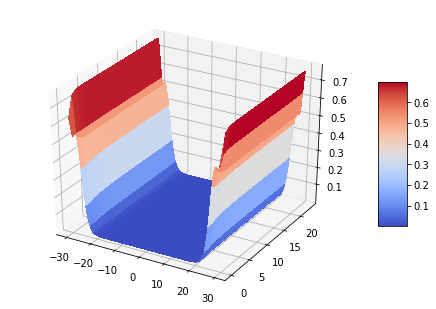

1.2242481708526611


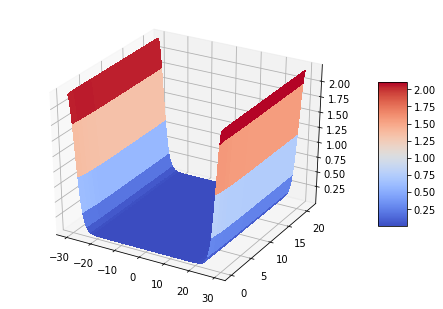

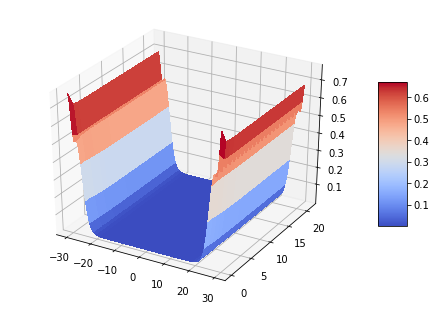

[0.010216259641885928, 0.00942684027989128, 0.008655231133370982, 0.007902880031608573, 0.007171747464714405, 0.006464516101616535, 0.0057849017586711305, 0.005138113399508599, 0.004531540386242947, 0.0039757677205836004, 0.0034859986772995794, 0.0030837450591414883, 0.0027978263320591057, 0.003435040652199212, 0.18805040763215095, 0.18916917700283514, 0.19254526573217007, 0.20067163002916688, 0.20388697995386185, 0.20258029058251661, 0.19971983357431308, 0.19508890248304311, 0.20187417241463454, 0.19848375410904992, 0.20313618001230593, 0.20090478347341834, 0.20358470363564254, 0.20240260756719766, 0.20331101291738402, 0.2030532836085027, 0.20142198057372415, 0.20194389941954938, 0.2024029229639334, 0.2033110129194432, 0.20305328361146077, 0.20241078318282554, 0.20294860917168248, 0.20229550119432838, 0.2001889151055095, 0.2008376610968768, 0.20142235446992315, 0.20194389970754556, 0.2031555636054903, 0.20270310636638594, 0.20083729641691797, 0.2014223542029703, 0.20294900137373867, 0

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess, './Weights_K=0/ddqn_best')
   
    rewards_infer, actions_infer = ddqn_infer(sess, K=0., alpha1_init=-15*np.pi/180, alpha2_init=-5*np.pi/180, alpha3_init=20*np.pi/180, alpha4_init=84*np.pi/180, alpha_change=ALPHA_CHANGE, max_step=60)

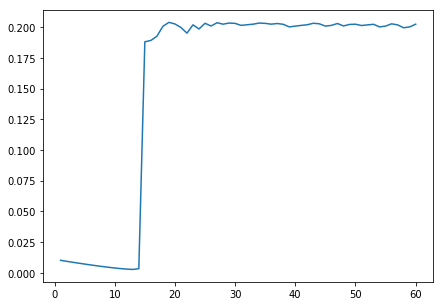

In [24]:
plt.figure(figsize=(7,5))
plt.plot(np.array(range(len(rewards_infer)))+1, rewards_infer)
plt.show()

In [25]:
np.sum(rewards_infer)

9.32434749822843

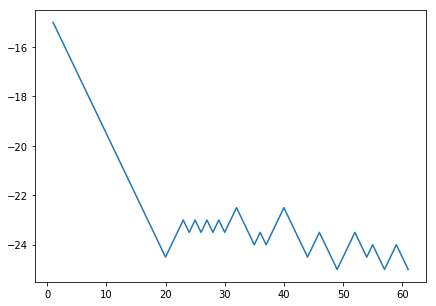

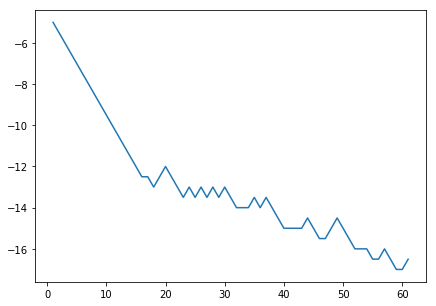

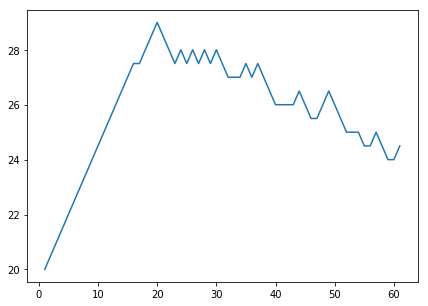

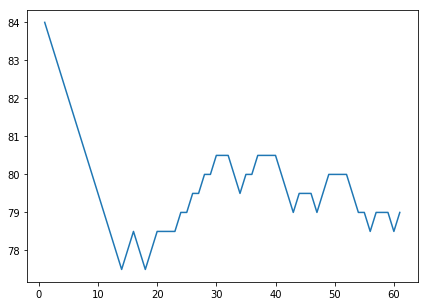

In [26]:
alpha1_cur = -15*np.pi/180
alpha2_cur = -5*np.pi/180
alpha3_cur = 20*np.pi/180
alpha4_cur = 84*np.pi/180

alpha1 = []
alpha2 = []
alpha3 = []
alpha4 = []

alpha1.append(180*alpha1_cur/np.pi)
alpha2.append(180*alpha2_cur/np.pi)
alpha3.append(180*alpha3_cur/np.pi)
alpha4.append(180*alpha4_cur/np.pi)
for i in range(len(actions_infer)):
    alpha1_cur += ALPHA_CHANGE[actions_infer[i]][0]
    alpha2_cur += ALPHA_CHANGE[actions_infer[i]][1]
    alpha3_cur += ALPHA_CHANGE[actions_infer[i]][2]
    alpha4_cur += ALPHA_CHANGE[actions_infer[i]][3]
    alpha1.append(180*alpha1_cur/np.pi)
    alpha2.append(180*alpha2_cur/np.pi)
    alpha3.append(180*alpha3_cur/np.pi)
    alpha4.append(180*alpha4_cur/np.pi)
    
plt.figure(figsize=(7,5))
plt.plot(np.array(range(len(alpha1)))+1, alpha1)
plt.show()
plt.figure(figsize=(7,5))
plt.plot(np.array(range(len(alpha2)))+1, alpha2)
plt.show()
plt.figure(figsize=(7,5))
plt.plot(np.array(range(len(alpha3)))+1, alpha3)
plt.show()
plt.figure(figsize=(7,5))
plt.plot(np.array(range(len(alpha4)))+1, alpha4)
plt.show()